# DeepFM과 네이버 영화데이터를 활용한 이용한 영화 추천시스템 구현

## 목차

* **1. DeepFM과 네이버 영화데이터를 활용한 이용한 영화 추천시스템 구현**
    * **1.1 목차**
    * **1.2 DeepFM 소개**
        - **1.2.1** Why DeepFM?
        - **1.2.2** DeepFM의 장점
    * **1.3 라이브러리 로드**
<br><br>
* **2. Naver 영화 데이터 수집**
  * **2.1 크롤링 함수 생성**
  * **2.2 크롤링을 위한 DataFrame 생성**
      - **2.1.1** get_movie_info 영화 제목, 평점, 장르, 국가, 개봉일 
      - **2.1.2** get_actor_director 감독, 배우 가져오는 함수
      - **2.1.3** get_prefer_info : 선호 연령 & 성별, 감상 포인트 가져오는 함수
      - **2.1.4** get_comment : 영화 평점 comment, id 가져오는 함수
      - **2.1.5** get_related_movie : 관련 영화 가져오기
  * **2.3 크롤링 수행(Multiprocessing)**
  * **2.4 출력된 엑셀 파일 병합**
  * **2.5 크롤링한 데이터의 한계 및 KMRD 데이터셋을 사용하는 이유**
<br><br>
* **3. DeepFM Class 구현**
    - **3.1 DeepFM 모델 설명**
        + **3.1.1** DeepFM의 구조
        + **3.1.2** DeepFM code 설명
           + **3.1.2.1** DeepFM Code의 구조
           + **3.1.2.2** FM_linear Class
           + **3.1.2.3** FeatureEmbedding Class
           + **3.1.2.4** FM_pairwise Class
           + **3.1.2.5** MultiLayerPerceptron Class
           + **3.1.2.6** DeepFM Class
    - **3.2 DeepFM 모델 구현**
<br><br>
* **4. KMRDataset Class 구현** 
    - **4.1 KMRD 데이터의 특징**
    - **4.2 데이터 로드 및 train, test set 분리**
<br><br>
* **5. DeepFM 모델 학습(GPU 설정)**
    - **5.1 Cost function, optimizer**
    - **5.2 Train data set으로 DeepFM 모델 학습**
    - **5.3 모델 저장 및 로드**
<br><br>
* **6. DeepFM 모델 테스트**
    - **6.1 Train dataset을 활용하여 DeepFM 모델 테스트**
    - **6.2 Test dataset을 활용하여 DeepFM 모델 테스트**
<br><br>
* **7. User i에게 Top-K 영화 추천**
    - **7.1 User에게 추천한 영화 정보 크롤링**
<br><br>
* **8. 결론 및 고찰**
<br><br>
* **9. Reference**


## DeepFM 소개

![deepfm](./image/deepfm.PNG)

* DeepFM CTR을 예측하는 모델로서, Factorization Machine과 DNN을 결합하여 만들었다.
* 다양한 feature들의 복잡한 관계를 파악해서 소비자들의 CTR(Click Through rate)를 극대화 하는 것이 추천시스템의 목표이다.
* 하지만, 지금(2016년)까지의 발견된 추천 시스템의 모델들은 low or high interaction에 Bias 되어 있었다.
* 또한, Domain 지식을 활용한 Feature Engineering을 필요로 하는 경우가 많았다.
* 이러한 부분을 해결하고자 Factorization Machine과 DNN을 활용한 DeepFM을 만들었다.

### Why DeepFM ?
![why DeepFM](./image/pdf1.PNG)


### DeepFM의 장점

|**Comparison of deep models for CTR prediction**|**Explanation**|
|------------------------------------------------------|-----------------|
|![CompareModel](./image/table1.PNG)|CTR을 예측하는 Deep model중에서 4개를 모두 만족하는 모델은 DeepFM이 유일하다.|

- **Factorization Machine과 DNN을 동시에 활용한다.**
    - 따라서, **Low-order-Feature와 High-order Feature를 모두 학습할 수 있다.** 

- **DeepFM은 End-to-end model을 추구한다.**
    - 기존의 FNN 모델은 FM을 학습 시킨 후 Input을 Embedding에 넣을 때 가중치를 주는 방식 이었지만, DeepFM은 FM Component와 Deep Component를 동시에 학습 시킨다.
    - 따라서, **DeepFM은 Pre-training 과정이 없다.**
- **Feature Engineering이 필요 없다.**
    - 최신(2016년 기준)의 가장 Hot한 모델인 Wide and Deep Model(Google)은 Input 값에 적절한 feature engineering이 필요했지만, DeepFM은 feature Engineering이 필요없다.

* 따라서, **DeepFM**이 더 **General**하고 **Effective**한 방법이다.

## 라이브러리 로드

### Colab 환경이면 drive mount 진행

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
##### Numpy, Pandas, Matplotlib 및 그래프 설정
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus=False)

##### 영화정보 수집을 위한 라이브러리 로드
import urllib.request as req
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
from bs4 import BeautifulSoup
import urllib.parse

##### 크롤링시 Multiprocessing & 시간 측정과 연관된 라이브러리 로드
import math
import tqdm
import time
from multiprocessing import Pool, Manager

##### 크롤링한 DataFrame을 csv파일로 저장한 후, 병합하기 위해 필요한 라이브러리 로드
import os
import glob

##### DeepFM 모델을 pytorch로 구현
import torch
import torch.nn.functional as F
import torch.optim as optim

##### 데이터셋을 torch에 연동하고, 데이터 로드를 진행하기 위한 라이브러리 로드
from torch.utils.data import DataLoader
import torch.utils.data

C:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Naver 영화 데이터 수집

## 크롤링 함수 생성

**다음의 데이터를 크롤링 했습니다.**
   - 한 페이지에 모든 정보가 존재하지 않았기에, 한 영화당 5개의 페이지를 접근하여 크롤링작업을 수행했습니다.
   * **`get_movie_info`** : 영화 제목, 평점, 장르, 국가, 개봉일
   * **`get_actor_director`** : 감독, 배우
   * **`get_prefer_info`** 선호 연령&성별, 감상포인트
   * **`get_comment`** 영화 평점 comment, id
   * **`get_related_movie`** 관련영화

### get_movie_info 영화 제목, 평점, 장르, 국가, 개봉일

In [19]:
# 영화 제목, 평점, 장르, 국가, 개봉일
def get_movie_info(movie_code) :
    '''
    영화 제목, 평점, 장르, 국가, 개봉일 받는 함수
    input : movie_code = 영화 코드
    return : mv_name_lst(이름), score_point_lst(관람객평점), spc_point_lst(기자평론가평점)
        net_point_lst(네티즌 평점), genre_lst(장르), nation_lst(국가), open_lst(개봉일)  
    '''
    
    mv_name_lst, score_point_lst, spc_point_lst, net_point_lst = [], [], [], []
    genre_lst, nation_lst, open_lst = [], [], []
    try :
        url = f"https://movie.naver.com/movie/bi/mi/point.naver?code={movie_code}"
        page = urlopen(url)
        soup = BeautifulSoup(page, 'html.parser')
    except HTTPError as e :
        print(f'{movie_code}, HTTP Error 입니다.', e)
    except URLError as e :
        print(f'{movie_code}, URL Error 입니다.', e)
    except :
        print(f'{movie_code}, 오류')
    else :
        # 영화 제목
        try :
            mv_info = soup.find('div', class_='mv_info')
            mv_name = mv_info.find('h3', class_='h_movie').a.get_text() .strip('\r\t\n')   
            mv_name_lst.append(mv_name)
        except :
            print(f'{movie_code}, 영화 제목 부분 오류')
        
        # 영화 평점            
        try :
            score = soup.find('a', id='actualPointPersentBasic').find_all('em')
            score_point = f"{score[0].get_text()}{score[1].get_text()}{score[2].get_text()}{score[3].get_text()}"
            score_point_lst.append(score_point)
        except :
            print(f'{movie_code}, 관람객 평점 부분 오류 ')

        try :
            spc_score = mv_info.find('div', class_='spc_score_area').find_all('em')[1:]
            spc_point = f"{spc_score[0].get_text()}{spc_score[1].get_text()}{spc_score[2].get_text()}{spc_score[3].get_text()}"
            spc_point_lst.append(spc_point)
        except :
            print(f'{movie_code}, 기자 평론가 평점 부분 오류 ')
        try :
            net_score = soup.find('a', id='pointNetizenPersentBasic').find_all('em')
            net_point = f"{net_score[0].get_text()}{net_score[1].get_text()}{net_score[2].get_text()}{net_score[3].get_text()}"
            net_point_lst.append(net_point)
        except :
            print(f'{movie_code}, 네티즌 평점 부분 오류 ')    
    
        
        # 영화 장르, 국가, 개봉일
        try :
            dl_tag = soup.find('dl', class_='info_spec')
            info = dl_tag.find_all('a')
        except :
            print(f'{movie_code}, 장르, 국가, 개봉일 접근 오류')
        else :
            try :
                for i in info :
                    if i['href'].find('genre') != -1 :
                        genre_lst.append(i.get_text().strip('\r\t\n'))
                    elif i['href'].find('nation') != -1 :
                        nation_lst.append(i.get_text().strip('\r\t\n'))
                    elif i['href'].find('open') != -1 :
                        open_lst.append(i.get_text().strip('\r\t\n'))
                    else :
                        pass
            except :
                print(f'{movie_code},  장르, 국가, 개봉일 접근 후 데이터 입력시 오류')
          
    return mv_name_lst, score_point_lst, spc_point_lst, net_point_lst, genre_lst, nation_lst, open_lst   

### get_actor_director 감독, 배우 가져오는 함수

In [20]:
def get_actor_director(movie_code) :
    '''
    영화 감독, 배우 가져오는 함수
    input : movie_code = 영화 코드
    return : actor_lst, director_lst : 배우, 감독을 담은 list형태
    '''
    actor_lst, director_lst = [], []
    try :
        url_ac = f"https://movie.naver.com/movie/bi/mi/detail.naver?code={movie_code}"
        page_ac = urlopen(url_ac)
        soup_ac = BeautifulSoup(page_ac, 'html.parser')
    except HTTPError as e :
        print(f'{movie_code}, HTTP Error 입니다.', e)
    except URLError as e :
        print(f'{movie_code}, URL Error 입니다.', e)
    except :
        print(f'{movie_code}, 오류')
    else :
        ###### 배우
        try :
            act = soup_ac.find('ul', class_ = 'lst_people')
            actor_name = act.find_all('a', class_='k_name')
        except :
            print('배우 태그 접근 오류')
        else :
            for a in actor_name :
                actor_lst.append(a.get_text().strip('\r\t\n'))

        ###### 감독
        try :        
            direc = soup_ac.find('div', class_='director')
            direc_name = direc.find_all('a', class_='k_name')
        except :
            print('감독 태그 접근 오류')
        else :
            for d in direc_name :
                director_lst.append(d.get_text().strip('\r\t\n'))
        
    return  actor_lst, director_lst

### get_prefer_info : 선호 연령 & 성별, 감상 포인트 가져오는 함수

In [21]:
def get_prefer_info(movie_code) :
    '''
    선호 연령, 성별, 감상 포인트 가져오는 함수
    input : movie_code = 영화 코드
    return : prefer_lst(선호 연령&성별), view_point_lst(감상포인트), directing_lst(연출 선호 비율) 
            acting_lst(연기 선호 비율), story_lst(스토리 선호 비율), v_beauty_lst(영상미 선호 비율), ost_lst(ost 선호 비율)
    '''
    prefer_lst, view_point_lst, directing_lst, acting_lst, story_lst, v_beauty_lst, ost_lst = [], [], [], [], [], [], []
    try :
        url_pv = f'https://movie.naver.com/movie/bi/mi/point.naver?code={movie_code}'
        page_pv = urlopen(url_pv)
        soup_pv = BeautifulSoup(page_pv, 'html.parser')
    except HTTPError as e :
        print(f'{movie_code}, HTTP Error 입니다.', e)
    except URLError as e :
        print(f'{movie_code}, URL Error 입니다.', e)
    except :
        print(f'{movie_code}, 오류')
    else :
        ## 선호 연령& 성별
        try :
            comment = soup_pv.find('strong', class_='grp_review').get_text()
        except :
            print('평점 없음')
        else :
            prefer_lst.append(comment[6:12])
            view_point_lst.append(comment[19:-12])


            # 감상포인트 선호 비율
            try : 
                view_point_rate = soup_pv.find('ul', class_='grp_point').find_all('span', class_='grp_score')
            except :
                print('감상 포인트 선호 비율 없음')
            else :
                directing_lst.append(view_point_rate[0].get_text().strip('\r\t\n'))
                acting_lst.append(view_point_rate[1].get_text().strip('\r\t\n'))
                story_lst.append(view_point_rate[2].get_text().strip('\r\t\n'))
                v_beauty_lst.append(view_point_rate[3].get_text().strip('\r\t\n'))
                ost_lst.append(view_point_rate[4].get_text().strip('\r\t\n'))
                
    return prefer_lst, view_point_lst, directing_lst, acting_lst, story_lst, v_beauty_lst, ost_lst

### get_comment : 영화 평점 comment, id 가져오는 함수

In [22]:
## 영화 평점, comment 가져오는 함수
def get_comment(movie_code) :
    '''
    영화 평점 id, comment를 가져오는 함수
    input : movie_code = 영화 코드
    return : {id, (score, comment)}의 dict형태를 담은 리스트
                - key : id
                - value : (score, comment)
    '''
    page_no = 0
    comment_lst = []
    try :
        url_comment = f"https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code={movie_code}&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page={page_no+1}"
        page_comment = urlopen(url_comment)
        soup_comment = BeautifulSoup(page_comment, 'html.parser')
        total_comment = int(soup_comment.find('strong', class_='total').em.get_text().strip('\r\t\n').replace(',', ""))
        page_total_no = math.ceil(total_comment/10) 
    except HTTPError as e :
        print(f'{movie_code}, HTTP Error 입니다.', e)
    except URLError as e :
        print(f'{movie_code}, URL Error 입니다.', e)
    except :
        print(f'{movie_code}, 평점 코멘트 부분 오류')
    else :  
        page_total_no = math.ceil(total_comment/10)  

        for page_no in range(page_total_no) :
            try : 
                url_comment = f"https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code={movie_code}&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page={page_no+1}"
                page_comment = urlopen(url_comment)
                soup_comment = BeautifulSoup(page_comment, 'html.parser')
            except HTTPError as e :
                print(f'{movie_code}, HTTP Error 입니다.', e)
            except URLError as e :
                print(f'{movie_code}, URL Error 입니다.', e)
            else :    
                for i in range(10) :
                    try :
                        comment_tag = soup_comment.find_all('div', class_='score_reple')[i]
                        comment = comment_tag.find('span', id=f'_filtered_ment_{i}').get_text().strip('\r\t\n')
                        comment_id = comment_tag.find_all('span')[-1].get_text().strip('\r\t\n')
                        comment_rate = soup_comment.find_all('div', class_='star_score')[i].em.get_text().strip('\r\t\n')
                        
                        # id와 comment를 dict형식으로 넣는다
                        comment_dict = dict({comment_id : (comment_rate ,comment)})
                        comment_lst.append(comment_dict)
                    
                    except:
                        pass  
                    
    return comment_lst

### get_related_movie : 관련 영화 가져오기

In [23]:
def get_related_movie(movie_code) :
    '''
    관련 영화 가져오는 함수
    input : movie_code = 영화 코드
    return : 
    '''
    relate_movie_lst = []
    try :
        url_relate = f"https://movie.naver.com/movie/bi/mi/scriptAndRelate.naver?code={movie_code}"
        page_relate = urlopen(url_relate)
        soup_relate = BeautifulSoup(page_relate, 'html.parser')
    except HTTPError as e :
        print(f'{movie_code}, HTTP Error 입니다.', e)
    except URLError as e :
        print(f'{movie_code}, URL Error 입니다.', e)
    except :
        print(f'{movie_code}, 오류')
    else :
        try :
            rm_lst = soup_relate.find_all('a', class_='movie_title')
            for rmovie in rm_lst :
                relate_movie_lst.append(rmovie.get_text().strip('\r\t\n'))
        except :
            print(f'{movie_code}, 관련 영화 관련 오류')
    return relate_movie_lst

## DataFrame 생성

In [ ]:
cols =['영화코드', '영화제목', '관람객평점', '기자평론가평점', '네티즌평점', '장르', '국가', '개봉일', 
        '배우', '감독', '선호연령성별', '감상포인트', '연출선호', '연기선호', '스토리선호', '영상미선호', 'ost선호',
      'comment', '관련영화']

df = pd.DataFrame(np.zeros((230000, 19)), columns=cols)
df

## 크롤링 수행 : multiprocessing

In [ ]:
# movie = list(range(10000, 10003))

def crawling_with_table(start_code, finish_code) :
    
    for i, movie_code in range(start_code, finish_code):
        print(f'-------------------------{start_code + i}번째------------------------------')
        print(i, movie_code)
        mv_name, score_point, spc_point, net_point, genre, nation, opend = get_movie_info(movie_code)
        if len(mv_name) == 0 :
            pass
        else :
            actor, director = get_actor_director(movie_code)
            prefer, view_point, directing, acting, story, v_beauty, ost = get_prefer_info(movie_code)
            comment = get_comment(movie_code)
            relate_movie = get_related_movie(movie_code)

            data_lst = [movie_code, mv_name, score_point, spc_point, net_point, genre, nation, opend,
                       actor, director,
                       prefer, view_point, directing, acting, story, v_beauty, ost,
                       comment, relate_movie]                                     
            for j, data in enumerate(data_lst) :
                if j == 0 :
                    df.iloc[i, j] = data
                elif len(data) == 1 :
                    df.iloc[i, j] = data[0]
                elif len(data) > 1 :
                    df.iloc[i, j] = str(data).strip("[]")
                else :
                    pass
    df.to_csv(f'./crawling/df_{start_code}_{finish_code}.csv', index=False)
    print('---------끝---------------------')

### Multiprocessig

In [ ]:
# 코어 20개로 크롤링하기(속도 x20배 빠르게)

def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()

if __name__=='__main__':
    start_time = time.time()
    inputs = [10001, 20001, 30001, 40001, 50001, 60001, 70001, 80001, 90001, 100001, 110001, 120001, 130001, 140001, 150001, 160001, 170001, 180001, 190001, 200001]
    outputs = [20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000]

    pool = Pool(processes=20)
    pool.starmap(crawling_with_table, zip(inputs, outputs))
    print("--- %s seconds ---" % (time.time() - start_time))

## 출력된 엑셀 파일 병합

+ colab과 다른 컴퓨터와 병행해서 크롤링을 수행했습니다!.

### glob을 통해 파일 위치 접근 후 csv파일만 불러온다

In [ ]:
csv_lst = glob.glob(pathname = './movie/*.csv')
read_csv_lst =[i[8:] for i in csv_lst]
read_csv_lst

##### csv파일을 반복문으로 합치기 위해서 첫번째 df를 미리 만들어 놓는다.

In [ ]:
i = read_csv_lst[0]
df_raw  = pd.read_csv(f"./movie/{i}")
df_first = df_raw[df_raw['영화코드']!=0].copy()
df_first

In [ ]:
for i in read_csv_lst[1:] :
    df_raw  = pd.read_csv(f"./movie/{i}")
    df_remove = df_raw[df_raw['영화코드']!=0].copy()
    df_first = df_first.append(df_remove)

## 다 끝나면 index를 reset해준다.
crwaling_final = df_first.reset_index(drop=True)

In [ ]:
crwaling_final = crwaling_final.sort_values(by='영화코드').reset_index(drop=True)
crwaling_final.to_csv('./df_final.csv', index=False)

## 크롤링한 데이터의 한계 및 KMRD 데이터셋을 사용하는 이유

In [ ]:
# 영화에 Comment 있는 부분만 추출
data = pd.read_csv('./df_final.csv')
data = data[data['comment'] != '0.0']

In [17]:
data.sample(3)

,영화코드,영화제목,관람객평점,기자평론가평점,네티즌평점,장르,국가,개봉일,배우,감독,선호연령성별,감상포인트,연출선호,연기선호,스토리선호,영상미선호,ost선호,comment,관련영화
8826,18988.0,라이언 일병 구하기,0.0,0.0,9.43,"'전쟁', '액션', '드라마'",미국,"' 1998', '.09.12'","'톰 행크스', '에드워드 번즈', '톰 시즈모어', '제레미 데이비스', '빈 디...",스티븐 스필버그,10대 남성,연출,26%,22%,22%,19%,12%,"{'PS십장생(dydq****)': ('10', '점수 적게줘서 미안 이것밖에 못주...","'퓨리', '더 킹: 독립 전쟁', '그린 존', '300: 제국의 부활', '보일..."
47020,62496.0,아름다운 죄,0.0,0.0,1.00,드라마,0.0,"' 1991', '.07.13'","'미라 풀란', '밀루틴 카라드직', '미라 반잭'",지브코 니콜릭,0.0,0.0,0.0,0.0,0.0,0.0,0.0,caca****,"'행복의 세가지 조건', '씨버너스', '테이크 어 딥 브레스', '몬테비디오, 갓..."
1573,11585.0,탈주자,0.0,0.0,8.64,"'액션', '범죄', '드라마', '멜로/로맨스', '스릴러'",미국,"' 1993', '.04.10'","'장 끌로드 반담', '로잔나 아퀘트', '키에란 컬킨', '테드 레빈', '티파니...",로버트 하몬,30대 남성,"스토리, 연출",31%,27%,31%,12%,0%,"{'ccung(wjsr****)': ('6', '액션보단 감성이 좀 더 풍부한 이례...","'블랙 위도우: 파이널 챕터', '마약전쟁', '천재 사기꾼 돈: 세상을 속여라',..."


|**User id 정보** | **User별 평점 페이지** |
|-------------|-------|
|![userid](./image/userid.PNG)|![userid2](./image/userid2.PNG)|

* **DeepFM을 사용하기 위해서는 User rating정보가 필요한데 이 부분에서 문제가 발생했습니다.**
* 앞자리만 같은 서로다른 유저들의 정보가 중복되어 Input데이터가 오염될 우려가 존재하여 사용하지 못했습니다.
* 유저별로 평점을 모아놓은 사이트를 찾아서 크롤링을 수행하려고 했으나, user id가 1700만개 이상이 존재했고, 그에 따라서 최소 1700만개의 사이트를 접근해야 했습니다..
    - 컴퓨터 Resource의 한계로 그렇게 진행하지 못했습니다..

* 그에 따라 KMRD dataset(Naver 영화 평점 데이터셋)을 사용하게 되었습니다.

# DeepFM model

## DeepFM 모델 설명

### DeepFM의 구조

![deepfm3](./image/deepfm3.PNG)

* **CTR prediction data**
    - CTR 데이터는 일반적으로 아래와 같은 특성을 가지고 있어서, 학습 과정에서 새로운 모델을 만들어야 했습니다. 
        + **Highly sparse**
        + **Super high-dimensional**
        + **Categorical-continuous-mixed**
        + **Grouped in fields**
    - 따라서 고차원의 데이터를 낮은 차원으로 압축 시키기 위해서 데이터를 낮은 차원으로 **사상(Embedding)**하는 과정을 거쳤습니다.
<br><br>
* **Share Input, Embedding layer**
    - DeepFM은 input data와 Embedding layer를 FM Component와 Deep Component가 공유합니다.
    - 또한, FM, Deep 부분이 동시에 학습되기 때문에 FNN 모델에서 필요한 Pre-training 과정이 없습니다.
<br><br>
* **FM Component & Deep Component**
    - DeepFM은 FM component와 Deep Component로 구분됩니다.
    - FM Component은 Factorization Machine의 기법을 사용하며, low-order feature interaction 부분을 학습합니다.
    - Deep Component는 DNN기법을 사용하며, high-order feature interaction 부분을 학습합니다.

### DeepFM 수식
![k](./image/k.PNG)

* DeepFM은 FM Component의 output과 Deep Component의 output의 합의 Sigmoid 값을 결과로 나타냅니다.
* CTR predict 값은 0, 1로 Binanary Classification이므로 0.5를 기준으로 나눕니다.

### DeepFM code 설명


* DeepFM 코드는 논문의 저자가 구현한 코드를 기반으로 제 데이터에 맞게 수정하였습니다.
* DeepFM 모델의 코드는 총 5개의 Class로 구성되어 있습니다.
    - FM_linear Class, FM_pairwise Class, FeatureEmbedding Class, MultiLayerPerceptron Class으로 각 부분에 대해서 구성을 했고
    - 이를 종합적으로 실행하여 Sigmoid값을 계산하는 DeepFM Class로 구성하였습니다.
#### DeepFM Code의 구조

|**DeepFM Code Structure**|
|-------------------------|
|![class](./image/d.PNG)|
|**DeepFM Code Structure with equation**|
|![class](./image/h2.PNG)|

* FM_linear Class는 Feature_Embedding Class에서 embedding이 진행된 후 input 값을 받지 않고, 자체적으로 embedding을 진행합니다.


#### FM_linear Class & FM_pairwise Class

|**FM_linear Class**|**FM_pairwise Class** |
|----------|----------------|
|![fm_linear2](./image/fm_linear2.PNG)|![fm2](./image/fm2.PNG) |

**FM_linear Class**

* **FM Component에서 feature들 간의 linear(Order-1)한 관계에 대한 정보**를 제공해주는 부분 입니다.
* Embedding을 위해서 categorical data를 numeric하게 변환하고, 숫자가 겹치지 않게, 각 컬럼의 최대 값을 누적으로 더해줍니다.
* 위에 언급했듯이, Class내에서 **자체적으로 Embedding을 진행**하는데 그 이유는, embedding에 의한 output size가 1으로, 다른 Class과 **output size가 다르기 때문**입니다.
<br><br>

**FM_pairwise Class** 
* **FM Component에서 feature들 간의 pairwise(Order-2)한 관계에 대한 정보**를 제공해주는 부분 입니다.
* Sparse한 데이터셋에 대해서 강력한 성능을 보여줍니다.
* 이 부분에서 Factorization Machine의 latent vector들의 관계를 학습합니다.
    - **Seems to high Complexity** : 실제로 모든 latent vector들의 관계에 대해서 계산해야 할거 같아서 연산량이 많아 보이지만
    - **Linear Complexity** : 검은 부분(오른쪽 아래 점선 박스)의 식의 도출과정에 의해 연산과정이 Linear하게 변환 됩니다.

#### FeatureEmbedding Class




|**FM_linear Class**|
|----------|
|![embedding2](./image/embedding2.PNG)|

**FeatureEmbedding Class** 

**Embedding**
* 전체 Input 데이터에(**User 86458, Movie 48891, Genre 27, Total 135376**) 대해서 Embedding을 진행하는 부분입니다.
    - User와 Movie의 Unique 값이 많아서 **32개의 차원으로 사상**을 진행했습니다.
* **각 feature(User, Movie, Genre)별로 Embedding이 진행**되어 한개의 135376 크기의 vector를 input 했을 때 총 32차원의 Embedding 데이터가 3개가 발생합니다.

* 각 Class별로 Embedding이 진행과, Embedding 후 데이터를 사용하는 방법에 차이가 있습니다.
    - **`3.1.3.5  DeepFM Class`**에 설명이 있습니다.
    
**Initializer**
* Embedding의 가중치의 초기화 함수는 **Xavier Uniform Initialization**를 사용했습니다.

#### MultiLayerPerceptron Class



|**FM_linear Class**|
|----------|
|![deep3](./image/deep3.PNG)|


**Hidden layer**
* 논문의 Hyper parameter study를 참고하여 Hidden layer를 구성했습니다.
    - **Hidden layer는 5층으로 구성**했고
    - 각각의 층의 **neurons은 256, 256, 128, 64, 32**개로 **Decreasing Network Shape**으로 구성했습니다.
        + 논문에 의하면 Decreasing Network Shape이 Logloss와 AUC에서 좋은 모습을 보여줬다고 한 점을 참고했습니다.
    -  Activation function은 **ReLU**로 설정 했습니다.
    - **Dropout은 0.2 ~ 0.3**으로 설정하였고, **first layer는 dropout을 설정하지 않았습니다**.
        + Input 정보를 손실시키고 싶지 않았고, 경험상 first layer에 대해서 dropout을 설정하지 않는 것이 좋았었습니다.

#### DeepFM Class



![class](./image/h2.PNG)

* DeepFM Class는 FM_linear, FM_pairwise, MultiLayerPereptron class에서 나온 값을 더하고 Sigmoid 함수에 넣어 결과를 출력해주는 부분 입니다.

In [ ]:
class DeepFM(torch.nn.Module) :

    def __init__(self, field_dims, embed_dim) :
        super().__init__()
        self.linear = FM_linear(field_dims)
        self.fm = FM_pairwise()
        self.embedding = FeaturesEmbedding(field_dims=field_dims, embed_dim=embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(input_dim=self.embed_output_dim)
        
    def forward(self, x) :
        embed_x = self.embedding(x)
        x = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embed_output_dim))

        return torch.sigmoid(x.squeeze(1))

**각 Class별 Embedding 방법**
* **FM_linear Class**는 자체적인 embedding을 진행하였습니다.
* **FM_pairwise Class**는 135376 size vector를 embedding 했을 때 나오는 3X32 embedding vector를 열별로 더하고 계산을 진행합니다.
* **MultiLayerPerceptron Class**는 3X32 embedding vector를 1X96으로 flatten한후 256개의 nueron을 갖는 hidden layer에 Input으로 넣습니다.

## DeepFM 모델 구현

* 모델의 코드는 저자가 구현한 코드를 기반으로 제 데이터에 맞게 수정하였습니다. 

In [2]:
class FM_linear(torch.nn.Module) :
    '''
    Calculating FactorizationMachine's low interaction output
    Reference :
        Steffen Rendle : Factorization Machines, 2010
    '''
    def __init__(self, field_dims, output_dim=1) :
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim, )))
        self.umg = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

    def forward(self, x) :
        '''
        x : Long tensor of size (batch_size, num_fields)
        if user_id is 1 ~ 100 and movie_id 1 ~ 100 and genre_id 1 ~ 20
            chage user_id, movie_id, genre_id to 1 ~ 100, 101 ~ 200, 201 ~ 221 for making Desne Embedding 
        '''
        x = x + x.new_tensor(self.umg).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias    
    
    
class FeaturesEmbedding(torch.nn.Module) : 
    '''
    Sparse Feature to Dense Embedding
    Using Xavier initializer for initialize Dense embedding weights
    '''
    def __init__(self, field_dims, embed_dim) :
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.users = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)
        
    def forward(self, x) :
        '''
        x : Long tensor of size (batch_size, num_fields)
        '''
        x = x + x.new_tensor(self.users).unsqueeze(0) 
        return self.embedding(x)
        

class FM_pairwise(torch.nn.Module) :
    '''
    Calculating FactorizationMachine's parwise interaction
    Reference :
        Steffen Rendle : Factorization MAchines, 2010
    '''
    def __init__(self):
        super().__init__()
        
    def forward(self, x) :
        '''
        x : Float tensor of size (batch_size, num_fields, embed_dim)
        '''
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        
        k = square_of_sum - sum_of_square
        pairwise_interaction = 0.5 * torch.sum(k, dim=1, keepdim=True)
        
        return pairwise_interaction

class MultiLayerPerceptron(torch.nn.Module) :

    def __init__(self, input_dim) :
        super().__init__()
        layers = list()
        
        # 1'st hidden layer - 512 feature, BatchNormalizer, ReLu Activation, Not Dropout 
        layers.append(torch.nn.Linear(input_dim, 256))
        layers.append(torch.nn.BatchNorm1d(256))
        layers.append(torch.nn.ReLU())
        
        # 2'nd hidden layer - 256 feature, BatchNormalizer, ReLu Activation, Dropout 30% 
        layers.append(torch.nn.Linear(256, 256))
        layers.append(torch.nn.BatchNorm1d(256))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Dropout(p=0.3))

        # 3'rd hidden layer - 128 feature, BatchNormalizer, ReLu Activation, Dropout 30% 
        layers.append(torch.nn.Linear(256, 128))
        layers.append(torch.nn.BatchNorm1d(128))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Dropout(p=0.3))

        # 4'th hidden layer - 64 feature, BatchNormalizer, ReLu Activation, Dropout 20%
        layers.append(torch.nn.Linear(128,64))
        layers.append(torch.nn.BatchNorm1d(64))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Dropout(p=0.2))
        
        # 5'th hidden layer - 32 feature, BatchNormalizer, ReLu Activation, Dropout 20%
        layers.append(torch.nn.Linear(64,32))
        layers.append(torch.nn.BatchNorm1d(32))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Dropout(p=0.2))        
        
        # output layer
        layers.append(torch.nn.Linear(32, 1))
        
        self.mlp = torch.nn.Sequential(*layers)
        
    def forward(self, x) :
        
        return self.mlp(x)

In [3]:
class DeepFM(torch.nn.Module) :
    '''
    Implementation of DeepFM
    Reference :
        H Guo, et al. DeepFM: A Factorization-Machine based Neural Network for CTR Prediction, 2017.
    '''
    def __init__(self, field_dims, embed_dim) :
        super().__init__()
        self.linear = FM_linear(field_dims)
        self.fm = FM_pairwise()
        self.embedding = FeaturesEmbedding(field_dims=field_dims, embed_dim=embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(input_dim=self.embed_output_dim)
        
    def forward(self, x) :
        '''
        x : Long tensor of size (batch_size, num_fields)
        '''
        embed_x = self.embedding(x)
        x = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embed_output_dim))

        return torch.sigmoid(x.squeeze(1))

# KMRDataset Class 구현

## KMRD 데이터의 특징

**내 정보를 추가하는 부분**

* **`good_movie_code_lst`(10점 주고 싶은 영화)** 
    * **Movie Code** : [44885, 49008, 70254, 119428, 125459, 134963, 96379, 115977, 69689]
    * **Movie Name** : [아이언맨, 아이언맨2, 아이언맨3,  베놈, 닥터 스트레인지, 라라랜드, 비긴 어게인, 베테랑, 셔터 아일랜드]

* **`bad_movie_code_lst`(9점 이하 영화)**
    * **Movie Code** : [39614, 92823, 152341, 75711]
    * **Movie Name** : [쏘우, 컨저링, 애나벨:인형의 주인, 킥 애스2:겁없는 녀석들]

**userid, moviecode, rate, genre 정보를 사용했습니다.**

In [4]:
class KMRDDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, good_movie_code_lst=None, bad_movie_code_lst=None):
        
        ## If new rating information is exists append new information else pass
        if (good_movie_code_lst==None) & (bad_movie_code_lst==None) :
            print('No New User')
            rate = pd.read_csv(os.path.join(data_path,'rates-5m.csv')).iloc[:, :3]
        else :
            rate = pd.read_csv(os.path.join(data_path,'rates-5m.csv')).iloc[:, :3]
            self.new_user_id = rate.user.max()+1
            print(f'new user: {self.new_user_id}.')
            new_user_rating = self.append_new_user(self.new_user_id, good_movie_code_lst, bad_movie_code_lst)
            rate = rate.append(new_user_rating, ignore_index=True)
        
        genres = pd.read_csv(os.path.join(data_path,'genres.csv'))
        data = rate.merge(right=genres, how='left', on='movie')[['user', 'movie', 'genre', 'rate']]
        
        self.user_to_index = {original: idx for idx, original in enumerate(data.user.unique())}
        self.movie_to_index = {original: idx for idx, original in enumerate(data.movie.unique())}
        self.genre_to_index = {original : idx for idx, original in enumerate(data.genre.unique())}
        data['user_e'] = data['user'].apply(lambda x: self.user_to_index[x])
        data['movie_e'] = data['movie'].apply(lambda x: self.movie_to_index[x])
        data['genre_e'] = data['genre'].apply(lambda x: self.genre_to_index[x])
        
        # Keeping Original DataFrame for Checking result
        self.data_original = data.copy()
        
        # From DataFrame to Numpy
        data = data[['user_e', 'movie_e', 'genre_e', 'rate']].to_numpy()[:, :4]
        
        # item : (user, movie, genre)
        self.items = data[:, :3].astype(np.int)  # -1 because ID begins from 1
        # if rating > 9 then 1 else 0
        self.targets = self.__preprocess_target(data[:, 3]).astype(np.float32)
        
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.long)
        self.movie_field_idx = np.array((1,), dtype=np.long)
        self.genre_field_idx = np.array((2,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[target <= 9] = 0
        target[target > 9] = 1
        return target
    
    def append_new_user(self, user_id, good_movie_code_lst, bad_movie_code_lst) :
        info_dict_lst = [] 
        # Append good_movie_code --- rate 10 
        for good_code in good_movie_code_lst :
            info_dict_lst.append({'user' :user_id , 'movie' :good_code, 'rate' : 10})
        # Append bad_movie_code ---- rate 1
        for bad_code in bad_movie_code_lst :
            info_dict_lst.append({'user' :user_id , 'movie' :bad_code, 'rate' : 1})
        new_user_rating = pd.DataFrame(info_dict_lst)
        
        return new_user_rating  

##### rating 분포의 특성 및 이진분류

In [3]:
rate = pd.read_csv(os.path.join('./rates-5m.csv')).iloc[:, :3]
rate

,user,movie,rate
0,0,10002,10
1,0,10003,9
2,0,10004,9
3,0,10005,5
4,0,10006,3
...,...,...,...
5031047,86456,140718,8
5031048,86456,141104,8
5031049,86456,144927,8
5031050,86456,145162,9


C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


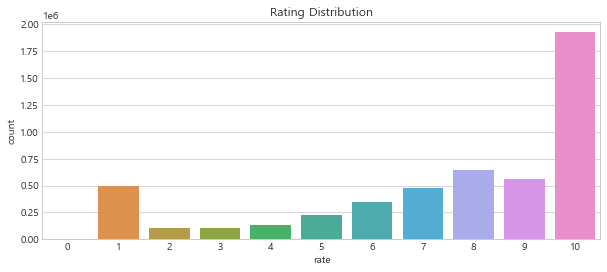

In [16]:
plt.figure(figsize=(10, 4))
sns.countplot(rate.rate);
plt.title('Rating Distribution');

* rate정보는 10점으로 편향되어 있습니다.
* 이런 rate의 특성에 기반해서 rate = 10인 데이터를 1(good movie) 나머지 를 0(bad movie)로 설정했습니다. 

## 데이터 로드 및 train, test set분리

**내 정보**

* **good_movie_code(10점 주고 싶은 영화)** 
    * **Movie Code** : [44885, 49008, 70254, 119428, 125459, 134963, 96379, 115977, 69689]
    * **Movie Name** : [아이언맨, 아이언맨2, 아이언맨3,  베놈, 닥터 스트레인지, 라라랜드, 비긴 어게인, 베테랑, 셔터 아일랜드]

* **bad_movie_code(9점 이하 영화)**
    * **Movie Code** : [39614, 92823, 152341, 75711]
    * **Movie Name** : [쏘우, 컨저링, 애나벨:인형의 주인, 킥 애스2:겁없는 녀석들]

In [5]:
data_path = '/content/drive/MyDrive/project'

good_movie_code_lst = [44885, 49008, 70254, 119428, 125459, 134963, 96379, 115977, 69689]
bad_movie_code_lst = [39614, 92823, 152341, 75711]
dataset = KMRDDataset(data_path=data_path, good_movie_code_lst=good_movie_code_lst, bad_movie_code_lst=bad_movie_code_lst)
dataset

new user: 86457.


In [6]:
#### train, test set 분리(80%, 20%)
train_length = int(len(dataset) * 0.8)
test_length = len(dataset) - train_length
train_dataset, test_dataset = torch.utils.data.random_split(dataset=dataset, lengths=(train_length, test_length))

In [7]:
# KMRDDataset클래스가 torch.utils.data.Dataset를 상속 받았으므로 torch의 DataLoder를 활용하여 데이터를 로드 가능
# 데이터 사이즈가 워낙 크기 때문에 batch_size를 100000으로 설정
train_data_loader = DataLoader(train_dataset, batch_size=100000)
test_data_loader = DataLoader(test_dataset, batch_size=100000)

In [63]:
##### KMRDDataset 객체인 dataset의 특징 살펴보기
print(dataset.user_field_idx)
print(dataset.movie_field_idx)
print(dataset.genre_field_idx)
print(dataset.field_dims)
print(sum(dataset.field_dims))
print(torch.nn.Embedding(sum(dataset.field_dims), 16))
print(torch.nn.Parameter(torch.zeros((1,))))
print(np.array((0, *np.cumsum(dataset.field_dims)[:-1]), dtype=np.long))

[0]
[1]
[2]
[86458 48891    27]
135376
Embedding(135376, 16)
Parameter containing:
tensor([0.], requires_grad=True)
[     0  86458 135349]


# DeepFM 모델 학습(GPU 설정)

In [60]:
# GPU로 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepFM(dataset.field_dims, embed_dim=32)

# Setting GPU to DeepFM model
model.to(device)

DeepFM(
  (linear): FM_linear(
    (fc): Embedding(135376, 1)
  )
  (fm): FM_pairwise()
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(135376, 32)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=96, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Dropout(p=0.3, inplace=False)
      (7): Linear(in_features=256, out_features=128, bias=True)
      (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Dropout(p=0.3, inplace=False)
      (11): Linear(in_features=128, out_features=64, bias=True)
      (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU()
  

## cost function, optimizer

In [64]:
# Binaray Cross Entropy Loss, Adam Optimizer
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-6)

## Train data set으로 DeepFM 모델 학습

In [65]:
losses = []
total_data = len(list(train_data_loader))
epochs = 50 
for epoch in range(epochs) :
    
    running_loss = 0.0
    for i, data in enumerate(train_data_loader) :
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    mean_loss = running_loss/total_data
    
    print('Epoch %d loss : %4f' % (epoch+1, mean_loss))
    losses.append(mean_loss)
    running_loss = 0.0
            
print('Finished Training')

Epoch 1 loss : 0.545049
Epoch 2 loss : 0.433770
Epoch 3 loss : 0.351768
Epoch 4 loss : 0.280855
Epoch 5 loss : 0.242088
Epoch 6 loss : 0.217049
Epoch 7 loss : 0.196907
Epoch 8 loss : 0.184148
Epoch 9 loss : 0.174261
Epoch 10 loss : 0.164290
Epoch 11 loss : 0.156128
Epoch 12 loss : 0.150816
Epoch 13 loss : 0.144534
Epoch 14 loss : 0.138455
Epoch 15 loss : 0.133652
Epoch 16 loss : 0.129335
Epoch 17 loss : 0.126301
Epoch 18 loss : 0.123784
Epoch 19 loss : 0.119648
Epoch 20 loss : 0.115656
Epoch 21 loss : 0.112745
Epoch 22 loss : 0.110817
Epoch 23 loss : 0.110044
Epoch 24 loss : 0.108656
Epoch 25 loss : 0.107099
Epoch 26 loss : 0.105334
Epoch 27 loss : 0.103403
Epoch 28 loss : 0.101551
Epoch 29 loss : 0.099790
Epoch 30 loss : 0.097730
Epoch 31 loss : 0.095514
Epoch 32 loss : 0.092930
Epoch 33 loss : 0.091377
Epoch 34 loss : 0.090713
Epoch 35 loss : 0.090222
Epoch 36 loss : 0.089926
Epoch 37 loss : 0.088395
Epoch 38 loss : 0.087133
Epoch 39 loss : 0.086389
Epoch 40 loss : 0.086064
Epoch 41 

### Loss값 시각화

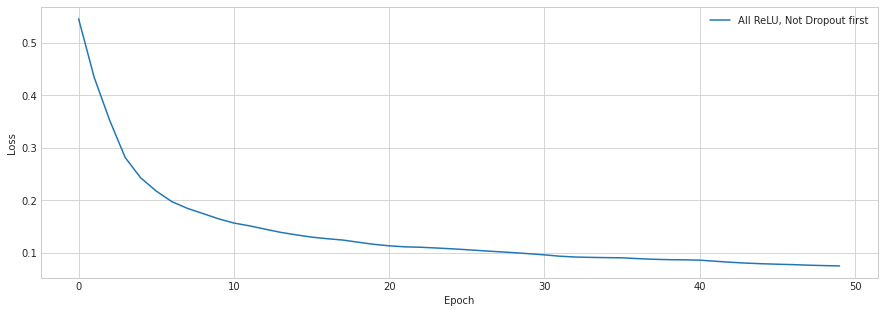

In [66]:
plt.figure(figsize=(15, 5))
plt.plot(range(epochs), losses, label='All ReLU, Not Dropout first')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 모델 저장 및 로드

In [70]:
# save DeepFM model
PATH = '/content/drive/MyDrive/project/DeepFM_AR_NDF.pth'
torch.save(model.state_dict(), PATH)

In [8]:
# load DeepFM model
PATH = '/content/drive/MyDrive/project/DeepFM_AR_NDF.pth'
DeepFM = DeepFM(dataset.field_dims, embed_dim=32)
DeepFM.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# DeepFM 모델 테스트

* Test 과정에서 모델이 추가적으로 학습하지 않도록 **`with torch.no_grad() :`** 안에서 테스트를 진행했습니다. 

## Train dataset을 활용하여 DeepFM 모델 테스트

In [72]:
# Accuracy for train
correct = 0
total = 0
with torch.no_grad() :
    for data in train_data_loader :
        inputs, labels = data
        
        outputs = DeepFM(inputs)
        outputs = torch.tensor([(1 if output > 0.5 else 0) for output in outputs], dtype=float)
        
        # total += batch_size
        total += labels.size(0)
        correct += (outputs == labels).sum().item()

print('Accuracy of the DeepFM on the train data : %d %%' % (100*correct/total))

Accuracy of the DeepFM on the test data : 97 %


## Test dataset을 활용하여 DeepFM 모델 테스트

In [9]:
# Accuracy for test data
correct = 0
total = 0
with torch.no_grad() :
    for data in test_data_loader :
        inputs, labels = data
        
        outputs = DeepFM(inputs)
        outputs = torch.tensor([(1 if output > 0.5 else 0) for output in outputs], dtype=float)
        
        # total += batch_size
        total += labels.size(0)
        correct += (outputs == labels).sum().item()

print('Accuracy of the DeepFM on the test data : %d %%' % (100*correct/total))

Accuracy of the DeepFM on the test data : 96 %


# User i에게 Top-K 영화 추천

* **New User(나)** 에게 Top-k 영화를 추천해주는 함수입니다.
* **KMRDDataset**의 객체인 dataset에 **`new_user_id`** 인스턴스로 New_User의 id 값을 저장했고, 이를 input값으로 넣어줬습니다.

In [14]:
# user에 대한 TOP-N 영화 추천 함수
def movie_recommend(i, k) :
    '''
    Movie Recommendation function for user_i
        i : user_id(= preprocessed user_id for input Embedding layer)
        k : Top-K Movies  
    '''
    # Change all user number to user who you want to recommend movie.   
    item, labels = dataset[:]
    item[: ,0]= i
    item_unique = set([tuple(item) for item in item.tolist()])
    user = torch.tensor(np.array(list(item_unique)))
    
    ## User i's favortie movie information DataFrame & movie code
    df_user_favorite = dataset.data_original[(dataset.data_original['user_e']==0) & (dataset.data_original['rate']>9)]
    user_favorite_movie_lst = df_user_favorite['movie']
    
    ## output : Sorting Sigmoid Values and get index & Sorting movie_code.
    with torch.no_grad() :
        outputs = DeepFM(user)
        outputs = outputs.sort(descending=True).indices
    user_favorite_predicted = list(np.array(dataset.data_original.iloc[outputs, :]['movie']))
    
    # Top-K other movies except those that users have previously marked as good.
    recommend_lst = []
    for data in user_favorite_predicted : 
        if data not in user_favorite_movie_lst:
            recommend_lst.append(data)
        if len(recommend_lst) == k:
            break
            
    return recommend_lst

In [48]:
recommend_lst = movie_recommend(dataset.new_user_id, 10)

## User에게 추천한 영화 정보 크롤링 해오기

* 기존에 크롤링한 데이터를 사용해서 접근할 수 있었지만, 메모리가 1.6GB를 잡아먹어서 로드하기 부담이 된 측면과.
* 위에서 작성한 크롤링 함수가 어떻게 작동하는지 보여드리고 싶어서 크롤링 함수를 넣었습니다. 

In [49]:
def recommend_movie_info(recommend_lst) :
    
    # Data Frame for movie information
    cols =['영화코드', '영화제목', '관람객평점', '기자평론가평점', '네티즌평점', '장르', '국가', '개봉일', 
        '배우', '감독', '선호연령성별', '감상포인트', '연출선호', '연기선호', '스토리선호', '영상미선호', 'ost선호']
    df = pd.DataFrame(np.zeros((len(recommend_lst), 17)), columns=cols)
    
    # Crawling Movie Information
    for i, movie_code in enumerate(recommend_lst):
        mv_name, score_point, spc_point, net_point, genre, nation, opend = get_movie_info(movie_code)
        if len(mv_name) == 0 :
            pass
        else :
            actor, director = get_actor_director(movie_code)
            prefer, view_point, directing, acting, story, v_beauty, ost = get_prefer_info(movie_code)
            data_lst = [movie_code, mv_name, score_point, spc_point, net_point, genre, nation, opend,
                       actor, director,
                       prefer, view_point, directing, acting, story, v_beauty, ost]                                     
            for j, data in enumerate(data_lst) :
                if j == 0 :
                    df.iloc[i, j] = data
                elif len(data) == 1 :
                    df.iloc[i, j] = data[0]
                elif len(data) > 1 :
                    df.iloc[i, j] = str(data).strip("[]")
                else :
                    pass
    return df


In [50]:
df_recommended_movie = recommend_movie_info(recommend_lst)

171336, 관람객 평점 부분 오류 
171336, 기자 평론가 평점 부분 오류 
171336, 네티즌 평점 부분 오류 
평점 없음
10187, 관람객 평점 부분 오류 
10187, 기자 평론가 평점 부분 오류 
10187, 네티즌 평점 부분 오류 
평점 없음
10200, 기자 평론가 평점 부분 오류 
11220, 관람객 평점 부분 오류 
11220, 기자 평론가 평점 부분 오류 
11220, 네티즌 평점 부분 오류 
평점 없음
11211, 관람객 평점 부분 오류 
11211, 기자 평론가 평점 부분 오류 
11211, 네티즌 평점 부분 오류 
평점 없음
64161, 관람객 평점 부분 오류 
64131, 관람객 평점 부분 오류 
64131, 기자 평론가 평점 부분 오류 
64131, 네티즌 평점 부분 오류 
평점 없음


In [51]:
df_recommended_movie

,영화코드,영화제목,관람객평점,기자평론가평점,네티즌평점,장르,국가,개봉일,배우,감독,선호연령성별,감상포인트,연출선호,연기선호,스토리선호,영상미선호,ost선호
0,171336.0,숨바꼭질,0,0,0,스릴러,미국,0,"'발 킬머', '패트릭 플러거', '폴 밴 빅터', '루이자 크로즈', '이얼 바즈...",스테판 릭,0,0,0,0,0,0,0
1,10187.0,13일의 금요일 2,0,0,0,공포,미국,0,"'에이미 스틸', '존 퍼리', '에이드리언 킹'",스티브 마이너,0,0,0,0,0,0,0
2,10200.0,터미네이터 2:오리지널,9.51,0,9.44,"'SF', '액션', '스릴러'","'미국', '프랑스'","'2019', '.10.24', '2013', '.11.14', ' 1991', '...","'아놀드 슈왈제네거', '린다 해밀턴', '에드워드 펄롱', '로버트 패트릭', '...",제임스 카메론,20대 남성,연출,24%,19%,22%,18%,17%
3,170267.0,너와 극장에서,8.65,6.00,7.09,드라마,한국,"' 2018', '.06.28'","'김예은', '이태경', '박현영', '문혜인', '김판겸', '신숙희', '팔로'...","'유지영', '정가영', '김태진'",20대 여성,연출,35%,29%,29%,0%,6%
4,11220.0,트루 크라임,0,0,0,"'범죄', '스릴러', '드라마'",미국,0,"'클린트 이스트우드', '아이제이아 워싱턴', '데니스 리어리', '리사 게이 해밀...",클린트 이스트우드,0,0,0,0,0,0,0
5,170456.0,미스터 스마일,8.01,6.50,7.94,"'드라마', '멜로/로맨스'",미국,"' 2018', '.12.27'","'로버트 레드포드', '케이시 애플렉', '씨씨 스페이식', '대니 글로버', '티...",데이빗 로워리,40대 남성,연기,12%,48%,16%,16%,8%
6,11211.0,스캐너스,0,0,0,"'공포', 'SF', '스릴러'",캐나다,0,"'제니퍼 오닐', '스티븐 랙', '패트릭 맥구한', '로렌스 데인', '마이클 아...",데이비드 크로넨버그,0,0,0,0,0,0,0
7,64161.0,엑스맨 탄생: 울버린,0,5.81,8.22,"'SF', '액션', '판타지', '스릴러'",미국,"' 2009', '.04.30'","'휴 잭맨', '리브 슈라이버', '대니 휴스턴', '린 콜린스'",개빈 후드,10대 남성,연기,21%,33%,21%,21%,5%
8,64131.0,스톱로스,0,0,0,"'전쟁', '드라마'",미국,0,"'라이언 필립', '애비 코니쉬', '채닝 테이텀', '조셉 고든 레빗', '롭 브...",킴벌리 피어스,0,0,0,0,0,0,0
9,170827.0,더 게스트,5.11,3.67,4.15,"'공포', '스릴러'","'스페인', '영국', '미국', '프랑스'","' 2018', '.09.12'","'레이첼 니콜스', '로라 해링'",미겔 앙헬 비바스,30대 여성,연출,33%,21%,25%,7%,13%


# 결론 및 고찰

**학습 시간**
* 학습 데이터가 약 500만 개 이상이었기 때문에 학습 시간이 너무 오래 걸렸습니다.
* 새로운 고객이 들어오면 데이터를 받아 학습 후 추천을 진행하게끔 설계되어 있었기 때문에 학습 시간이 길다는 문제를 개선해야 한다고 생각합니다.
    - 개선 방법 1. 컴퓨터의 리소스를 증가시키고, 병렬학습을 진행한다.
    - 개선 방법 2. 입력 데이터의 수를 줄인다.

**추천 결과**
* 실제로 추천된 영화 중에서 `터미네이터 2:오리지널`, `엑스맨 탄생: 울버린` 2개는 제가 실제로 좋아하는 영화였습니다.
* 또한, bad_movie_lst에 공포영화가 다수 존재했는데, 공포영화가 추천되었습니다.
    - 이렇듯, 추천 시스템의 결과에 대해서 명확하게 설명할 수 없는 단점이 있었습니다.

# Reference

* **DeepFM** : https://www.ijcai.org/proceedings/2017/0239.pdf
* **Factorization Machine** : https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf